In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
PATH = "drive/My Drive/FoodDemandForecasting/"

In [0]:
train = pd.read_csv(f'{PATH}train.csv')
meal_info = pd.read_csv(f'{PATH}meal_info.csv')
fulfillment = pd.read_csv(f'{PATH}fulfilment_center_info.csv')
test = pd.read_csv(f'{PATH}test_QoiMO9B.csv')
submission = pd.read_csv(f'{PATH}sample_submission_hSlSoT6.csv')

## Data Preparation

In [0]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [0]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [0]:
fulfillment.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [0]:
train_meal = pd.merge(train,meal_info,how="inner",on="meal_id")
train_df = pd.merge(train_meal,fulfillment,on="center_id",how="inner")

In [0]:
train_df.shape

(456548, 15)

In [0]:
train.shape

(456548, 9)

In [0]:
test_meal = pd.merge(test,meal_info,how="inner",on="meal_id")
test_df = pd.merge(test_meal,fulfillment,on="center_id",how="inner")

In [0]:
test.shape

(32573, 8)

In [0]:
test_df.shape

(32573, 14)

In [0]:
## since the evaluation is based on RMSLE ,
#train_df['num_orders'] = np.log(train_df['num_orders']) + 1

In [0]:
train_df_main = train_df.copy()
test_df_main = test_df.copy()

In [0]:
def rmsle(x,y):
  return np.sqrt(((x-y) ** 2).mean())

def print_score(m):
  print("RMSE train,RMSE valid,score train,score valid")
  all_metrics = [rmsle(m.predict(X_train),y_train), rmsle(m.predict(X_valid),y_valid),
                 m.score(X_train,y_train),m.score(X_valid,y_valid)]
  if hasattr(m,"oob_score_"):
    all_metrics.append(m.oob_score_)
  return all_metrics 

## Feature engineering

In [0]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0


In [0]:
train_df['month'] = train_df['week'].apply(lambda x: int(x/4))
train_df['year'] = train_df['week'].apply(lambda x: int(x/52))
train_df['quarter'] = train_df['week'].apply(lambda x: int(x/13))

test_df['month'] = test_df['week'].apply(lambda x: int(x/4))
test_df['year'] = test_df['week'].apply(lambda x: int(x/52))
test_df['quarter'] = test_df['week'].apply(lambda x: int(x/13))

In [0]:
train_df['checkout_per_base'] = train_df['checkout_price'] / train_df['base_price']
test_df['checkout_per_base'] = test_df['checkout_price'] / test_df['base_price']

In [0]:
train_df['category_cuisine'] = train_df['cuisine'] +"_"+ train_df['category']
test_df['category_cuisine'] = test_df['cuisine'] +"_"+ test_df['category']

In [0]:
train_df['category_cuisine'].value_counts()

Indian_Rice Bowl         33408
Italian_Beverages        33381
Italian_Sandwich         33291
Continental_Pizza        33138
Thai_Beverages           32659
Continental_Beverages    32554
Thai_Starters            29941
Thai_Other Snacks        29379
Indian_Beverages         29296
Indian_Desert            29294
Italian_Salad            28559
Italian_Pasta            27694
Continental_Seafood      26916
Indian_Biryani           20614
Thai_Extras              13562
Thai_Soup                12675
Continental_Fish         10187
Name: category_cuisine, dtype: int64

In [0]:
train_df.corr()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area,month,year,quarter,checkout_per_base
id,1.000000,0.002225,0.002641,0.000488,0.001941,0.002909,0.002001,0.003111,0.000702,-0.000387,-0.000648,-0.000090,0.002220,0.001454,0.002130,-0.002910
week,0.002225,1.000000,-0.003450,0.019814,0.026581,0.028614,-0.000841,-0.008263,-0.017210,0.000405,0.004600,0.001550,0.999640,0.940404,0.995927,0.017437
center_id,0.002641,-0.003450,1.000000,0.009893,0.001348,0.000604,0.013658,-0.005043,-0.053035,0.061078,-0.003426,-0.111869,-0.003453,-0.002844,-0.003508,0.005302
meal_id,0.000488,0.019814,0.009893,1.000000,0.010748,0.002605,0.013402,0.016354,0.010597,-0.003198,-0.001662,-0.001546,0.019776,0.016642,0.019752,0.045715
checkout_price,0.001941,0.026581,0.001348,0.010748,1.000000,0.953389,0.004818,-0.057184,-0.282108,-0.004805,-0.003648,0.021569,0.026652,0.027494,0.026615,0.185213
base_price,0.002909,0.028614,0.000604,0.002605,0.953389,1.000000,0.171173,0.057156,-0.222306,-0.002054,-0.001934,0.018031,0.028598,0.029464,0.028580,-0.090994
emailer_for_promotion,0.002001,-0.000841,0.013658,0.013402,0.004818,0.171173,1.000000,0.390534,0.277147,-0.005234,-0.007462,-0.019462,-0.000605,0.004931,-0.001216,-0.477564
homepage_featured,0.003111,-0.008263,-0.005043,0.016354,-0.057184,0.057156,0.390534,1.000000,0.294490,0.008640,0.003605,0.041498,-0.008308,0.006089,-0.007722,-0.338011
num_orders,0.000702,-0.017210,-0.053035,0.010597,-0.282108,-0.222306,0.277147,0.294490,1.000000,0.041596,0.029744,0.176976,-0.017024,-0.013514,-0.017029,-0.205188
city_code,-0.000387,0.000405,0.061078,-0.003198,-0.004805,-0.002054,-0.005234,0.008640,0.041596,1.000000,0.042686,0.131476,0.000392,0.000731,0.000483,-0.011755


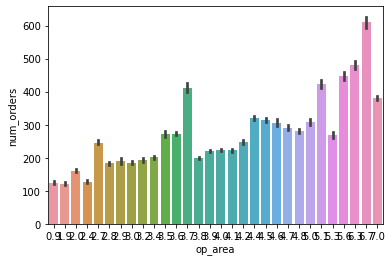

In [0]:
sns.barplot(x="op_area",y='num_orders',data=train_df)
plt.show()

In [0]:
train_df['op_area'].describe()

count    456548.000000
mean          4.083590
std           1.091686
min           0.900000
25%           3.600000
50%           4.000000
75%           4.500000
max           7.000000
Name: op_area, dtype: float64

In [0]:
## changing the op area to category
train_df['op_area_cat'] = pd.cut(np.array(train_df['op_area']), 3,labels=[1,2,3])
test_df['op_area_cat'] = pd.cut(np.array(test_df['op_area']), 3,labels=[1,2,3])

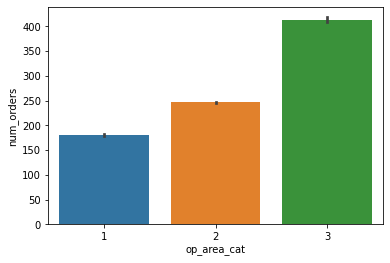

In [0]:
sns.barplot(x="op_area_cat",y='num_orders',data=train_df)
plt.show()

In [0]:
train_df.loc[train_df['checkout_price'] < train_df['base_price'], 'C'] = 1
train_df.loc[train_df['checkout_price'] > train_df['base_price'], 'C'] = 2
train_df.loc[train_df['checkout_price'] == train_df['base_price'], 'C'] = 0

test_df.loc[test_df['checkout_price'] < test_df['base_price'], 'C'] = 1
test_df.loc[test_df['checkout_price'] > test_df['base_price'], 'C'] = 2
test_df.loc[test_df['checkout_price'] == test_df['base_price'], 'C'] = 0

In [0]:
train_df['checkout_cat'] = pd.cut(np.array(train_df['checkout_price']),bins=4,labels=[1,2,3,4])
train_df['base_cat'] = pd.cut(np.array(train_df['base_price']),bins=4,labels=[1,2,3,4])

test_df['checkout_cat'] = pd.cut(np.array(test_df['checkout_price']),bins=4,labels=[1,2,3,4])
test_df['base_cat'] = pd.cut(np.array(test_df['base_price']),bins=4,labels=[1,2,3,4])

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
le = LabelEncoder()

In [0]:
train_df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'month', 'year', 'quarter', 'checkout_per_base', 'category_cuisine',
       'op_area_cat', 'C', 'checkout_cat', 'base_cat'],
      dtype='object')

In [0]:
columns_encode = ['cuisine','category','city_code','region_code','center_type','category_cuisine']
for column in columns_encode:
  le.fit(train_df[column])
  train_df[column] = le.transform(train_df[column])
  test_df[column] = le.transform(test_df[column])

In [0]:
avg_order_group = train_df.groupby(by=['center_id','meal_id'])['num_orders'].mean().reset_index()

In [0]:
avg_order_group.rename(columns={"num_orders":"avg_order"},inplace=True)
train_df = train_df.merge(avg_order_group,how="left",on=['center_id','meal_id'])
test_df = test_df.merge(avg_order_group,how="left",on=['center_id','meal_id'])

## Initial Processing using light boost models

In [0]:
import lightgbm as lgb

In [0]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,month,year,quarter,checkout_per_base,category_cuisine,op_area_cat,C,checkout_cat,base_cat,avg_order
0,1379560,1,55,1885,136.83,152.29,0,0,177,0,3,30,3,2,2.0,0,0,0,0.898483,12,1,1.0,1,1,230.324138
1,1018704,2,55,1885,135.83,152.29,0,0,323,0,3,30,3,2,2.0,0,0,0,0.891917,12,1,1.0,1,1,230.324138
2,1196273,3,55,1885,132.92,133.92,0,0,96,0,3,30,3,2,2.0,0,0,0,0.992533,12,1,1.0,1,1,230.324138
3,1116527,4,55,1885,135.86,134.86,0,0,163,0,3,30,3,2,2.0,1,0,0,1.007415,12,1,2.0,1,1,230.324138
4,1343872,5,55,1885,146.50,147.50,0,0,215,0,3,30,3,2,2.0,1,0,0,0.993220,12,1,1.0,1,1,230.324138


In [0]:
train_df.dtypes

id                          int64
week                        int64
center_id                   int64
meal_id                     int64
checkout_price            float64
base_price                float64
emailer_for_promotion       int64
homepage_featured           int64
num_orders                  int64
category                    int64
cuisine                     int64
city_code                   int64
region_code                 int64
center_type                 int64
op_area                   float64
month                       int64
year                        int64
quarter                     int64
checkout_per_base         float64
category_cuisine            int64
op_area_cat              category
C                         float64
checkout_cat             category
base_cat                 category
avg_order                 float64
dtype: object

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'month', 'year', 'quarter', 'checkout_per_base', 'category_cuisine',
       'op_area_cat', 'C', 'checkout_cat', 'base_cat', 'avg_order'],
      dtype='object')

In [0]:
X = train_df[['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'month', 'year', 'quarter', 'checkout_per_base', 'category_cuisine',
       'op_area_cat', 'C', 'checkout_cat', 'base_cat',
       'avg_order']]
y = train_df['num_orders']

In [0]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.3,random_state=88)

In [0]:
m = lgb.LGBMRegressor()
m.fit(X_train,y_train)
print_score(m)

RMSE train,RMSE valid,score train,score valid


[138.77104407412455, 143.5475352621215, 0.8777271003203513, 0.8670810376139876]

In [0]:
X_test = test_df[['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'month', 'year', 'quarter', 'checkout_per_base', 'category_cuisine',
       'op_area_cat', 'C', 'checkout_cat', 'base_cat',
       'avg_order']]

In [0]:
X_test['avg_order'].fillna(0,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [0]:
test_df.shape

(32573, 24)

In [0]:
prediction = m.predict(X_test)

In [0]:
pd.DataFrame({'id':test_df['id'],'num_orders':prediction}).to_csv("submission_lgbm_nolog.csv",index=False)

### Random Forest

In [0]:
X.dtypes

week                        int64
center_id                   int64
meal_id                     int64
checkout_price            float64
base_price                float64
emailer_for_promotion       int64
homepage_featured           int64
category                    int64
cuisine                     int64
city_code                   int64
region_code                 int64
center_type                 int64
op_area                   float64
month                       int64
year                        int64
quarter                     int64
checkout_per_base         float64
category_cuisine            int64
op_area_cat              category
C                         float64
checkout_cat             category
base_cat                 category
avg_order                 float64
dtype: object

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
m = RandomForestRegressor(n_estimators=10,oob_score=True) #100 estimators
m.fit(X_train,y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RMSE train,RMSE valid,score train,score valid


[64.69250147366535,
 145.47319520566487,
 0.9734270121656272,
 0.8634909582178946,
 0.8034886146124278]

In [0]:
prediction = m.predict(X_test)

In [0]:
prediction.shape

(32573,)

In [0]:
pd.DataFrame({'id':test_df['id'],'num_orders':prediction}).to_csv("submission_rf_nolog.csv",index=False)

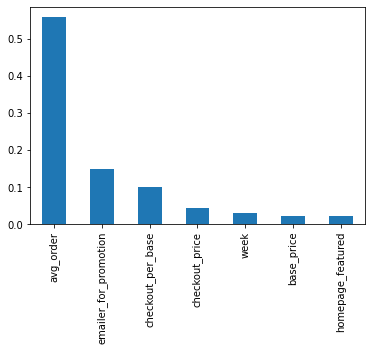

In [0]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(7).plot(kind='bar')

In [0]:
## RMSLE is 55

In [0]:
def combine_df(train_df,test_df):
  train_df['is_train'] = 1
  test_df['is_train'] = 0
  test_df['avg_order'].fillna(0,inplace=True)
  combined = pd.concat([train_df,test_df],axis=0)
  return combined
combined_df = combine_df(train_df,test_df)

In [0]:
combined_df.isnull().sum()

id                           0
week                         0
center_id                    0
meal_id                      0
checkout_price               0
base_price                   0
emailer_for_promotion        0
homepage_featured            0
num_orders               32573
category                     0
cuisine                      0
city_code                    0
region_code                  0
center_type                  0
op_area                      0
month                        0
year                         0
quarter                      0
checkout_per_base            0
category_cuisine             0
op_area_cat                  0
C                            0
checkout_cat                 0
base_cat                     0
avg_order                    0
is_train                     0
dtype: int64

In [0]:
combined_df.sort_values(by="week",inplace=True)

In [0]:
def last3orders(df):
  final_df = pd.DataFrame()
  for center in df['center_id'].unique():
    center_df = df.loc[df['center_id'] == center,:]
    for meal in center_df['meal_id'].unique():
      center_meal_df = center_df.loc[center_df['meal_id'] == meal,:]
      center_meal_df['last_order'] = center_meal_df['num_orders'].shift(periods=1)
      center_meal_df['last_2_orders'] = center_meal_df['num_orders'].shift(periods=2)
      center_meal_df['last_3_orders'] = center_meal_df['num_orders'].shift(periods=3)
      final_df = pd.concat([final_df,center_meal_df],axis=0)
  return final_df
#final_df = last3orders(combined_df)

In [0]:
final_df.to_csv("final_df.csv",index=False)

## Final Dataframe 

In [0]:
final_df = pd.read_csv(f'{PATH}final_df.csv')

In [0]:
final_df['week_sin'] = np.sin(2 * np.pi * final_df['week'] / 52.143)
final_df['week_cos'] = np.cos(2 * np.pi * final_df['week'] / 52.143)

In [0]:
train_df_final = final_df.loc[final_df['is_train'] == 1,:]
test_df_final = final_df.loc[final_df['is_train'] == 0,:]

In [132]:
final_df.shape

(489121, 31)

In [133]:
train_df_final.isnull().sum()

id                           0
week                         0
center_id                    0
meal_id                      0
checkout_price               0
base_price                   0
emailer_for_promotion        0
homepage_featured            0
num_orders                   0
category                     0
cuisine                      0
city_code                    0
region_code                  0
center_type                  0
op_area                      0
month                        0
year                         0
quarter                      0
checkout_per_base            0
category_cuisine             0
op_area_cat                  0
C                            0
checkout_cat                 0
base_cat                     0
avg_order                    0
is_train                     0
last_order                3597
last_2_orders             7191
last_3_orders            10785
week_sin                     0
week_cos                     0
dtype: int64

In [8]:
# in train_df_final, we can fill 0 
train_df_final.fillna(0,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [0]:
X = train_df_final[['week_sin','week_cos', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'month', 'year', 'quarter', 'checkout_per_base', 'category_cuisine',
       'op_area_cat', 'C', 'checkout_cat', 'base_cat',
       'avg_order']]
y = train_df_final['num_orders']

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.3,random_state=88)

In [136]:
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor(n_estimators=100,oob_score=True) #100 estimators
m.fit(X_train,y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [137]:
print_score(m)

RMSE train,RMSE valid,score train,score valid


[52.393808706553465,
 136.0266735359419,
 0.982834884568476,
 0.8761135416154207,
 0.8754827398900767]

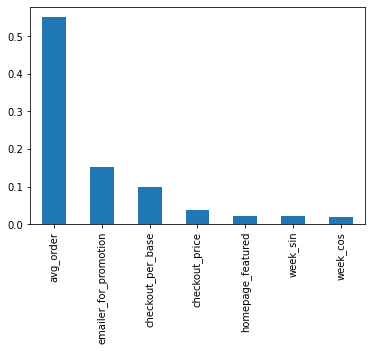

In [138]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(7).plot(kind='bar')
plt.show()

In [0]:
import lightgbm

In [0]:
m = lightgbm.LGBMRegressor(learning_rate=0.003,
                          n_estimators=40000,
                          silent=False)

In [148]:
m.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.003, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=40000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
X_test = test_df_final[['week_sin','week_cos', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'month', 'year', 'quarter', 'checkout_per_base', 'category_cuisine',
       'op_area_cat', 'C', 'checkout_cat', 'base_cat',
       'avg_order']]
y_pred = m.predict(X_test)


In [0]:
#y_pred_lgb = m.predict(X_test)
pd.DataFrame({'id':test_df_final['id'],'num_orders':y_pred_lgb}).to_csv("submission_rf_new1.csv",index=False)

In [0]:
#y_pred_lgb = m.predict(X_test)
pd.DataFrame({'id':test_df_final['id'],'num_orders':y_pred_lgb}).to_csv("lightgbm_sub.csv",index=False)

In [0]:
y_pred_lgb = y_pred_lgb.clip(min=0)

In [0]:
test_df_final.shape

(32573, 27)

In [0]:
test_df_no_null = test_df_final.dropna(axis=0,inplace=False)

In [0]:
test_df_no_null.shape

(3545, 27)

In [0]:
X_test = test_df_no_null[['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'month', 'year', 'quarter', 'checkout_per_base', 'category_cuisine',
       'op_area_cat', 'C', 'checkout_cat', 'base_cat',
       'avg_order','last_order','last_2_orders','last_3_orders']]
y_pred = m.predict(X_test)


(26, 27)

In [0]:
pd.concat([test_df_no_null.reset_index(inplace=False),pd.Series(y_pred)],axis=1)

,index,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area,month,year,quarter,checkout_per_base,category_cuisine,op_area_cat,C,checkout_cat,base_cat,avg_order,last_order,last_2_orders,last_3_orders,0
0,145,1028232,146,55,1885,158.11,159.11,0,0,0,3,30,3,2,2.0,36,2,11,0.993715,12,1,1.0,1,1,230.324138,121.0,162.0,176.0,146.40
1,237,1192413,146,55,2304,486.03,484.03,0,0,2,1,30,3,2,2.0,36,2,11,1.004132,6,1,2.0,2,2,24.265060,14.0,26.0,55.0,27.08
2,337,1497398,146,55,2704,320.13,321.13,0,0,5,3,30,3,2,2.0,36,2,11,0.996886,14,1,1.0,1,1,32.336957,42.0,53.0,13.0,23.54
3,455,1152412,146,55,1525,320.13,319.13,0,0,5,3,30,3,2,2.0,36,2,11,1.003134,14,1,2.0,1,1,34.165138,13.0,28.0,41.0,25.86
4,574,1175393,146,55,2867,726.53,727.53,0,0,11,0,30,3,2,2.0,36,2,11,0.998625,3,1,1.0,3,3,44.702703,15.0,109.0,95.0,28.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,488757,1364079,146,137,2490,290.03,292.03,0,0,9,2,17,3,0,4.4,36,2,11,0.993151,10,2,1.0,1,1,651.254098,256.0,204.0,269.0,299.37
3541,488887,1435797,146,137,2569,340.47,340.47,0,0,9,2,17,3,0,4.4,36,2,11,1.000000,10,2,0.0,2,1,444.433333,689.0,837.0,257.0,438.44
3542,488978,1278837,146,137,1571,641.23,639.23,0,0,4,0,17,3,0,4.4,36,2,11,1.003129,1,2,2.0,3,3,120.320988,134.0,81.0,188.0,101.73
3543,489070,1172455,146,137,2956,639.23,640.23,0,0,4,0,17,3,0,4.4,36,2,11,0.998438,1,2,1.0,3,3,103.768293,69.0,108.0,121.0,87.95


In [0]:
final_df.shape

(489121, 29)

In [0]:
import pickle

In [0]:
pickle.dump(m, open("randomforest.pkl", 'wb'))

In [0]:
final_df_v1 = final_df.loc[final_df['week'] >= 144,:]

In [69]:
final_df_v1.loc[final_df_v1['is_train'] == 0,"is_predicted"] = 0
final_df_v1.loc[final_df_v1['is_train'] == 1,"is_predicted"] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [70]:
final_df_v1['is_predicted'].value_counts()

0.0    32573
1.0     6570
Name: is_predicted, dtype: int64

In [71]:
test_df_final.shape

(32573, 29)

In [72]:
test_df_final.head(2)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,month,year,quarter,checkout_per_base,category_cuisine,op_area_cat,C,checkout_cat,base_cat,avg_order,is_train,last_order,last_2_orders,last_3_orders
145,1028232,146,55,1885,158.11,159.11,0,0,NaN,0,3,30,3,2,2.0,36,2,11,0.993715,12,1,1.0,1,1,230.324138,0,121.0,162.0,176.0
146,1262649,147,55,1885,159.11,159.11,0,0,NaN,0,3,30,3,2,2.0,36,2,11,1.000000,12,1,0.0,1,1,230.324138,0,NaN,121.0,162.0


In [0]:
def perform_prediction(final_df,m):
  test_df_final = final_df.loc[final_df['is_predicted'] == 0,:]
  test_df_no_null = test_df_final.drop(columns="num_orders",axis=1).dropna(axis=0)
  if(test_df_no_null.shape[0] == 0):
    test_df_no_null = test_df_final.drop(columns="num_orders",axis=1).fillna(0)
  X_test = test_df_no_null[['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'month', 'year', 'quarter', 'checkout_per_base', 'category_cuisine',
       'op_area_cat', 'C', 'checkout_cat', 'base_cat',
       'avg_order','last_order','last_2_orders','last_3_orders']]
  y_pred = m.predict(X_test)
  test_predictions = pd.concat([test_df_no_null.reset_index(inplace=False),pd.Series(y_pred)],axis=1)  
  test_predictions.rename(columns={0:"num_orders"},inplace=True)
  test_predictions['is_predicted'] = 1
  test_predictions = test_predictions[['meal_id','center_id','week','num_orders','is_predicted']]
  df = pd.merge(final_df,test_predictions,left_on=['meal_id','center_id','week'],right_on=['meal_id','center_id','week'],how="left")
  df.num_orders_x.fillna(df.num_orders_y,inplace=True)
  df.rename(columns={'num_orders_x':'num_orders'},inplace=True)
  df.drop(columns = "num_orders_y",axis=1,inplace=True)
  df.loc[df['is_predicted_y'] == 1,'is_predicted_x'] = 1
  df.drop(columns = "is_predicted_y",axis=1,inplace=True)
  df.rename(columns={"is_predicted_x":'is_predicted'},inplace=True)
  
  return df

In [95]:
test_dataframe = pd.DataFrame()
counter = 0
final_df_v2 = final_df_v1.copy()
while(test_dataframe.shape[0] <= 32573):
  df = perform_prediction(final_df_v2,m)
  test_dataframe = pd.concat([test_dataframe,df[(df['is_train']==0) & (df['is_predicted'] == 1)]],axis=0)
  test_dataframe.drop_duplicates(keep="first",inplace=True,ignore_index=True)
  final_df_v2 = last3orders(df)
  counter += 1
  print(counter)
  if(counter == 15):
    break
  else:
    pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

10


In [0]:
test_dataframe.drop_duplicates(ignore_index=True,inplace=True)

In [97]:
test_dataframe.shape

(33811, 30)

In [0]:
mydf = pd.merge(test_df_final,test_dataframe,on="id",how="left")

In [0]:
mydf['id'].drop_duplicates(keep="first",inplace=True)

In [109]:
mydf.shape

(32573, 58)

In [0]:
mydf.num_orders_x.fillna(mydf.num_orders_y,inplace=True)

In [0]:
sub = pd.read_csv("sub_rf.csv")

In [0]:
final = pd.merge(mydf,sub,on="id")

In [0]:
final['num_orders_x'].fillna(final['num_orders'],inplace=True)

In [122]:
final['num_orders_x'].isnull().sum()

0

In [0]:
submission = final[['id','num_orders_x']]

In [124]:
submission.rename(columns={'num_orders_x':'num_orders'},inplace=True)
submission.to_csv("submission_last3.csv",index=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [127]:
submission.shape

(32573, 2)

In [106]:
test_df_final.shape

(32573, 29)

In [47]:
df1.head(3)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,month,year,quarter,checkout_per_base,category_cuisine,op_area_cat,C,checkout_cat,base_cat,avg_order,is_train,last_order,last_2_orders,last_3_orders,is_predicted
0,1292806,146.0,89.0,1571.0,150.35,152.35,0,0,64.77,0,3,30,3,2,2.0,36,2,11,0.986872,12,1,1.0,1,1,230.324138,1,NaN,NaN,NaN,1.0
1480,1428992,144.0,89.0,1571.0,590.73,592.73,0,0,69.00,4,0,49,3,0,4.8,36,2,11,0.996626,1,2,1.0,3,3,85.466667,1,64.77,NaN,NaN,1.0
1481,1109906,145.0,89.0,1571.0,640.23,640.23,0,0,26.00,4,0,49,3,0,4.8,36,2,11,1.000000,1,2,0.0,3,3,85.466667,1,69.00,64.77,NaN,1.0


In [45]:
df['num_orders'].isnull().sum()

28822

In [29]:
final_df_v1['is_predicted'].value_counts()

0.0    32341
1.0     6802
Name: is_predicted, dtype: int64

In [0]:
df.shape

(489121, 29)

In [0]:
final_df.shape

(489121, 29)

In [0]:
df.num_orders_x.fillna(df.num_orders_y,inplace=True)

In [0]:
final_df.isnull().sum()

id                           0
week                         0
center_id                    0
meal_id                      0
checkout_price               0
base_price                   0
emailer_for_promotion        0
homepage_featured            0
num_orders               32573
category                     0
cuisine                      0
city_code                    0
region_code                  0
center_type                  0
op_area                      0
month                        0
year                         0
quarter                      0
checkout_per_base            0
category_cuisine             0
op_area_cat                  0
C                            0
checkout_cat                 0
base_cat                     0
avg_order                    0
is_train                     0
last_order               32625
last_2_orders            32693
last_3_orders            32789
dtype: int64

In [0]:
df.isnull().sum()

id                            0
week                          0
center_id                     0
meal_id                       0
checkout_price                0
base_price                    0
emailer_for_promotion         0
homepage_featured             0
num_orders_x              29028
category                      0
cuisine                       0
city_code                     0
region_code                   0
center_type                   0
op_area                       0
month                         0
year                          0
quarter                       0
checkout_per_base             0
category_cuisine              0
op_area_cat                   0
C                             0
checkout_cat                  0
base_cat                      0
avg_order                     0
is_train                      0
last_order                32625
last_2_orders             32693
last_3_orders             32789
num_orders_y             485576
dtype: int64

In [0]:
## Try to use vaex  (refer krish naik channel) . final_df is in drive

In [0]:
train_df['last_order'] = train_df['num_orders'].shift(periods=1)
train_df['last_2_orders'] = train_df['num_orders'].shift(periods=2)
train_df['last_3_orders'] = train_df['num_orders'].shift(periods=3)

In [0]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,month,year,quarter,checkout_per_base,category_cuisine,op_area_cat,C,checkout_cat,base_cat,avg_order,last_order,last_2_orders,last_3_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177,0,3,30,3,2,2.0,0,0,0,0.898483,12,1,1.0,1,1,230.324138,NaN,NaN,NaN
1,1018704,2,55,1885,135.83,152.29,0,0,323,0,3,30,3,2,2.0,0,0,0,0.891917,12,1,1.0,1,1,230.324138,177.0,NaN,NaN
2,1196273,3,55,1885,132.92,133.92,0,0,96,0,3,30,3,2,2.0,0,0,0,0.992533,12,1,1.0,1,1,230.324138,323.0,177.0,NaN
3,1116527,4,55,1885,135.86,134.86,0,0,163,0,3,30,3,2,2.0,1,0,0,1.007415,12,1,2.0,1,1,230.324138,96.0,323.0,177.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,0,3,30,3,2,2.0,1,0,0,0.993220,12,1,1.0,1,1,230.324138,163.0,96.0,323.0


## Pycaret

In [0]:
!pip install pycaret

## Catboost approach

In [0]:
!pip install catboost
!pip install scikit-learn==0.21
!pip install fastai==0.7.0


     |████████████████████████████████| 6.6MB 2.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


     |████████████████████████████████| 122kB 2.6MB/s 
     |████████████████████████████████| 496.4MB 25kB/s 
     |████████████████████████████████| 1.5MB 47.7MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2666429 sha256=630d1533d346d5d7ba7aa515a948436359689ece29cd659e70845c7d7e31be3c
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [0]:
from fastai.imports import *
from fastai.structured import *

from sklearn.ensemble import RandomForestRegressor
from pandas_summary import DataFrameSummary
import catboost

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_cats(train_df)
apply_cats(test_df,train_df)

In [0]:
X,y,nas = proc_df(train_df,y_fld = "num_orders")
X_test,_,_ = proc_df(test_df)

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X.drop("id",axis=1),y,test_size=0.3,random_state=88)

In [0]:
m = catboost.CatBoostRegressor()
m.fit(X_train,y_train)


Learning rate set to 0.108947
0:	learn: 1.1531701	total: 124ms	remaining: 2m 3s
1:	learn: 1.0966529	total: 193ms	remaining: 1m 36s
2:	learn: 1.0484590	total: 251ms	remaining: 1m 23s
3:	learn: 1.0075062	total: 307ms	remaining: 1m 16s
4:	learn: 0.9732720	total: 364ms	remaining: 1m 12s
5:	learn: 0.9451162	total: 422ms	remaining: 1m 9s
6:	learn: 0.9202047	total: 479ms	remaining: 1m 7s
7:	learn: 0.8944472	total: 537ms	remaining: 1m 6s
8:	learn: 0.8737200	total: 592ms	remaining: 1m 5s
9:	learn: 0.8573584	total: 649ms	remaining: 1m 4s
10:	learn: 0.8408809	total: 705ms	remaining: 1m 3s
11:	learn: 0.8215005	total: 764ms	remaining: 1m 2s
12:	learn: 0.8053894	total: 821ms	remaining: 1m 2s
13:	learn: 0.7939209	total: 879ms	remaining: 1m 1s
14:	learn: 0.7858608	total: 935ms	remaining: 1m 1s
15:	learn: 0.7777313	total: 990ms	remaining: 1m
16:	learn: 0.7666492	total: 1.05s	remaining: 1m
17:	learn: 0.7587972	total: 1.11s	remaining: 1m
18:	learn: 0.7494873	total: 1.17s	remaining: 1m
19:	learn: 0.744573

TypeError: ignored

In [0]:
print_score(m)

RMSE train,RMSE valid,score train,score valid


[0.4887538427078974,
 0.4953073781242707,
 0.8392754632686856,
 0.8349287089055546]

In [0]:
y_pred_catboost = m.predict(X_test.drop("id",axis=1))

In [0]:
pd.DataFrame({"id":X_test['id'],'num_orders':y_pred_catboost}).to_csv("Submission_catboost.csv",index=False)

In [0]:
m = RandomForestRegressor(oob_score=True)
m.fit(X_train,y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RMSE train,RMSE valid,score train,score valid


[0.21293786123590108,
 0.5067073373875355,
 0.9694924319932335,
 0.827242727091823,
 0.6205336687005528]

In [0]:
y_pred_rf = m.predict(X_test.drop("id",axis=1))

In [0]:
pd.DataFrame({"id":X_test['id'],'num_orders':y_pred_rf}).to_csv("Submission_rf.csv",index=False)

## Feature engineering

In [0]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,6.176150,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,6.777652,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,5.564348,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,6.093750,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,6.370638,Beverages,Thai,647,56,TYPE_C,2.0


In [0]:
train_df['op_area'].describe()

count    456548.000000
mean          4.083590
std           1.091686
min           0.900000
25%           3.600000
50%           4.000000
75%           4.500000
max           7.000000
Name: op_area, dtype: float64

In [0]:
train_df[train_df['base_price'] < train_df['checkout_price']]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
3,1116527,4,55,1885,135.86,134.86,0,0,6.093750,Beverages,Thai,647,56,TYPE_C,2.0
7,1461167,8,55,1885,146.53,145.53,0,0,5.905275,Beverages,Thai,647,56,TYPE_C,2.0
9,1018130,10,55,1885,144.56,143.56,0,0,6.164786,Beverages,Thai,647,56,TYPE_C,2.0
10,1047565,11,55,1885,146.53,144.53,0,0,6.497168,Beverages,Thai,647,56,TYPE_C,2.0
13,1196793,14,55,1885,142.62,141.62,0,0,5.905275,Beverages,Thai,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456526,1315719,124,61,2104,583.03,581.03,0,0,3.639057,Fish,Continental,473,77,TYPE_A,4.5
456529,1372283,127,61,2104,631.53,630.53,0,0,4.332205,Fish,Continental,473,77,TYPE_A,4.5
456540,1241284,138,61,2104,631.53,630.53,0,1,6.010635,Fish,Continental,473,77,TYPE_A,4.5
456545,1029231,143,61,2104,583.03,581.03,0,0,4.688879,Fish,Continental,473,77,TYPE_A,4.5


In [0]:
def combine_data():
  train_df['is_train'] = 1
  test_df['is_train'] = 0
  return pd.concat([train_df,test_df],axis=0)
combined_df = combine_data()

In [0]:
combined_df['discount'] = combined_df['base_price'] - combined_df['checkout_price']

In [0]:
combined_df.corr()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area,is_train,discount
id,1.000000,0.000802,0.003058,0.000297,0.000938,0.002028,0.001959,0.002869,-0.001363,-0.000401,-0.000659,-0.000141,0.002799,0.003789
week,0.000802,1.000000,-0.003492,0.018833,0.029952,0.026561,-0.006604,-0.016973,-0.008281,0.000287,0.004606,0.001760,-0.425673,-0.006755
center_id,0.003058,-0.003492,1.000000,0.009811,0.001084,0.000201,0.013327,-0.005062,-0.055560,0.061032,-0.003761,-0.111663,0.001107,-0.002786
meal_id,0.000297,0.018833,0.009811,1.000000,0.012980,0.004450,0.010569,0.015426,0.030081,-0.003290,-0.002232,-0.001755,-0.003521,-0.026526
checkout_price,0.000938,0.029952,0.001084,0.012980,1.000000,0.954192,0.005925,-0.056988,-0.389116,-0.004689,-0.002784,0.022795,-0.015667,-0.000320
base_price,0.002028,0.026561,0.000201,0.004450,0.954192,1.000000,0.171606,0.056252,-0.329368,-0.001924,-0.000973,0.019211,-0.003634,0.298890
emailer_for_promotion,0.001959,-0.006604,0.013327,0.010569,0.005925,0.171606,1.000000,0.394478,0.227207,-0.005125,-0.007176,-0.019552,0.013512,0.554659
homepage_featured,0.002869,-0.016973,-0.005062,0.015426,-0.056988,0.056252,0.394478,1.000000,0.248002,0.008135,0.002760,0.040660,0.022426,0.369775
num_orders,-0.001363,-0.008281,-0.055560,0.030081,-0.389116,-0.329368,0.227207,0.248002,1.000000,0.030150,0.029696,0.195052,NaN,0.135611
city_code,-0.000401,0.000287,0.061032,-0.003290,-0.004689,-0.001924,-0.005125,0.008135,0.030150,1.000000,0.042790,0.131554,0.000126,0.008524


In [0]:
combined_df['homepage_featured'].describe()

count    489121.000000
mean          0.107346
std           0.309552
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: homepage_featured, dtype: float64

In [0]:
combined_df['week'].describe()

count    489121.000000
mean         79.810613
std          44.343325
min           1.000000
25%          42.000000
50%          81.000000
75%         118.000000
max         155.000000
Name: week, dtype: float64

In [0]:
## Week of the year
combined_df['week_of_the_year'] = combined_df['week'] % 52

In [0]:
combined_df['center_type'].value_counts()

TYPE_A    281597
TYPE_C    106602
TYPE_B    100922
Name: center_type, dtype: int64

In [0]:
combined_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,is_train,discount,week_of_the_year
0,1379560,1,55,1885,136.83,152.29,0,0,6.176150,Beverages,Thai,647,56,TYPE_C,2.0,1,15.46,1
1,1018704,2,55,1885,135.83,152.29,0,0,6.777652,Beverages,Thai,647,56,TYPE_C,2.0,1,16.46,2
2,1196273,3,55,1885,132.92,133.92,0,0,5.564348,Beverages,Thai,647,56,TYPE_C,2.0,1,1.00,3
3,1116527,4,55,1885,135.86,134.86,0,0,6.093750,Beverages,Thai,647,56,TYPE_C,2.0,1,-1.00,4
4,1343872,5,55,1885,146.50,147.50,0,0,6.370638,Beverages,Thai,647,56,TYPE_C,2.0,1,1.00,5


In [0]:
combined_df['region_code'].value_counts()

56    204911
34    124978
77    101300
85     32521
23      6883
71      6761
93      6133
35      5634
Name: region_code, dtype: int64

In [0]:
combined_df['category'].value_counts()

Beverages       136781
Rice Bowl        35717
Sandwich         35599
Pizza            35444
Starters         31925
Other Snacks     31483
Desert           31407
Salad            30868
Pasta            29621
Seafood          28613
Biryani          21951
Extras           14554
Soup             13640
Fish             11518
Name: category, dtype: int64

## Label Encoding

In [0]:
combined_df['category'] = combined_df['category'].astype("category")
combined_df['cuisine'] = combined_df['cuisine'].astype("category")
combined_df['center_type'] = combined_df['center_type'].astype("category")

In [0]:
train_df = combined_df[combined_df['is_train'] == 1]
test_df = combined_df[combined_df['is_train'] == 0]

In [0]:
import lightgbm as lgb

In [0]:
train_df.drop("is_train",axis=1,inplace=True)
test_df.drop("is_train",axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,discount,week_of_the_year
0,1379560,1,55,1885,136.83,152.29,0,0,6.176150,Beverages,Thai,647,56,TYPE_C,2.0,15.46,1
1,1018704,2,55,1885,135.83,152.29,0,0,6.777652,Beverages,Thai,647,56,TYPE_C,2.0,16.46,2
2,1196273,3,55,1885,132.92,133.92,0,0,5.564348,Beverages,Thai,647,56,TYPE_C,2.0,1.00,3
3,1116527,4,55,1885,135.86,134.86,0,0,6.093750,Beverages,Thai,647,56,TYPE_C,2.0,-1.00,4
4,1343872,5,55,1885,146.50,147.50,0,0,6.370638,Beverages,Thai,647,56,TYPE_C,2.0,1.00,5


In [0]:
test_df.drop("num_orders",inplace=True,axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area,discount,week_of_the_year
0,1028232,146,55,1885,158.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0,1.0,42
1,1262649,147,55,1885,159.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0,0.0,43
2,1453211,149,55,1885,157.14,158.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0,1.0,45
3,1262599,150,55,1885,159.14,157.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0,-2.0,46
4,1495848,151,55,1885,160.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0,-1.0,47


In [0]:
test_df.shape

(32573, 17)

In [0]:
df = pd.DataFrame()
for center_id in train_df['center_id'].unique():
  center_train = train_df.loc[train_df['center_id'] == center_id,:]
  center_test = test_df.loc[test_df['center_id'] == center_id,:]
  center_train.drop(["id","discount","week_of_the_year"],axis=1,inplace=True)
  center_test1 = center_test.drop(['discount','week_of_the_year'],axis=1)
  for category in center_train['category'].unique():
    center_train_cuisine = center_train.loc[center_train['category'] == category,:]
    center_test_cuisine = center_test1.loc[center_test1['category'] == category,:]
    center_test_cuisine1 = center_test_cuisine.drop(['id'],axis=1)
    m = lgb.LGBMRegressor()
    m.fit(center_train_cuisine.drop(["num_orders"],axis=1),center_train_cuisine['num_orders'])
    pred_result = m.predict(center_test_cuisine1)
    df = df.append(pd.DataFrame({"id":center_test_cuisine['id'],"num_orders":pred_result}))


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


   week  center_id  meal_id  ...  region_code  center_type  op_area
0   146         55     1885  ...           56       TYPE_C      2.0
1   147         55     1885  ...           56       TYPE_C      2.0
2   149         55     1885  ...           56       TYPE_C      2.0
3   150         55     1885  ...           56       TYPE_C      2.0
4   151         55     1885  ...           56       TYPE_C      2.0

[5 rows x 13 columns]
     week  center_id  meal_id  ...  region_code  center_type  op_area
100   146         55     2290  ...           56       TYPE_C      2.0
101   147         55     2290  ...           56       TYPE_C      2.0
102   148         55     2290  ...           56       TYPE_C      2.0
103   149         55     2290  ...           56       TYPE_C      2.0
104   150         55     2290  ...           56       TYPE_C      2.0

[5 rows x 13 columns]
     week  center_id  meal_id  ...  region_code  center_type  op_area
130   146         55     2577  ...           56       TY

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


     week  center_id  meal_id  ...  region_code  center_type  op_area
452   146         24     2290  ...           85       TYPE_B      3.6
453   147         24     2290  ...           85       TYPE_B      3.6
454   148         24     2290  ...           85       TYPE_B      3.6
455   149         24     2290  ...           85       TYPE_B      3.6
456   150         24     2290  ...           85       TYPE_B      3.6

[5 rows x 13 columns]
     week  center_id  meal_id  ...  region_code  center_type  op_area
482   146         24     2577  ...           85       TYPE_B      3.6
483   147         24     2577  ...           85       TYPE_B      3.6
484   148         24     2577  ...           85       TYPE_B      3.6
485   149         24     2577  ...           85       TYPE_B      3.6
486   150         24     2577  ...           85       TYPE_B      3.6

[5 rows x 13 columns]
     week  center_id  meal_id  ...  region_code  center_type  op_area
719   146         24     2306  ...          

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


     week  center_id  meal_id  ...  region_code  center_type  op_area
927   146         11     2290  ...           56       TYPE_A      3.7
928   147         11     2290  ...           56       TYPE_A      3.7
929   148         11     2290  ...           56       TYPE_A      3.7
930   149         11     2290  ...           56       TYPE_A      3.7
931   150         11     2290  ...           56       TYPE_A      3.7

[5 rows x 13 columns]
     week  center_id  meal_id  ...  region_code  center_type  op_area
957   146         11     2577  ...           56       TYPE_A      3.7
958   147         11     2577  ...           56       TYPE_A      3.7
959   148         11     2577  ...           56       TYPE_A      3.7
960   149         11     2577  ...           56       TYPE_A      3.7
961   150         11     2577  ...           56       TYPE_A      3.7

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
1197   146         11     2306  ...        

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
1430   146         83     2577  ...           77       TYPE_A      5.3
1431   147         83     2577  ...           77       TYPE_A      5.3
1432   148         83     2577  ...           77       TYPE_A      5.3
1433   149         83     2577  ...           77       TYPE_A      5.3
1434   150         83     2577  ...           77       TYPE_A      5.3

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
1641   146         83     2306  ...           77       TYPE_A      5.3
1642   147         83     2306  ...           77       TYPE_A      5.3
1643   148         83     2306  ...           77       TYPE_A      5.3
1644   149         83     2306  ...           77       TYPE_A      5.3
1645   150         83     2306  ...           77       TYPE_A      5.3

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
1449   146         83     2826 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
1832   146         32     2290  ...           34       TYPE_A      3.8
1833   147         32     2290  ...           34       TYPE_A      3.8
1834   148         32     2290  ...           34       TYPE_A      3.8
1835   149         32     2290  ...           34       TYPE_A      3.8
1836   150         32     2290  ...           34       TYPE_A      3.8

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
1862   146         32     2577  ...           34       TYPE_A      3.8
1863   147         32     2577  ...           34       TYPE_A      3.8
1864   148         32     2577  ...           34       TYPE_A      3.8
1865   149         32     2577  ...           34       TYPE_A      3.8
1866   150         32     2577  ...           34       TYPE_A      3.8

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
2078   147         32     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
2265   146         13     2290  ...           56       TYPE_B      6.7
2266   147         13     2290  ...           56       TYPE_B      6.7
2267   148         13     2290  ...           56       TYPE_B      6.7
2268   149         13     2290  ...           56       TYPE_B      6.7
2269   150         13     2290  ...           56       TYPE_B      6.7

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
2295   146         13     2577  ...           56       TYPE_B      6.7
2296   147         13     2577  ...           56       TYPE_B      6.7
2297   148         13     2577  ...           56       TYPE_B      6.7
2298   149         13     2577  ...           56       TYPE_B      6.7
2299   150         13     2577  ...           56       TYPE_B      6.7

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
2545   146         13     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
2771   146        109     2290  ...           56       TYPE_A      3.6
2772   147        109     2290  ...           56       TYPE_A      3.6
2773   148        109     2290  ...           56       TYPE_A      3.6
2774   149        109     2290  ...           56       TYPE_A      3.6
2775   150        109     2290  ...           56       TYPE_A      3.6

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
2801   146        109     2577  ...           56       TYPE_A      3.6
2802   147        109     2577  ...           56       TYPE_A      3.6
2803   148        109     2577  ...           56       TYPE_A      3.6
2804   149        109     2577  ...           56       TYPE_A      3.6
2805   150        109     2577  ...           56       TYPE_A      3.6

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
3020   146        109     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
3212   146         52     2290  ...           56       TYPE_B      5.6
3213   147         52     2290  ...           56       TYPE_B      5.6
3214   148         52     2290  ...           56       TYPE_B      5.6
3215   149         52     2290  ...           56       TYPE_B      5.6
3216   150         52     2290  ...           56       TYPE_B      5.6

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
3242   146         52     2577  ...           56       TYPE_B      5.6
3243   147         52     2577  ...           56       TYPE_B      5.6
3244   148         52     2577  ...           56       TYPE_B      5.6
3245   149         52     2577  ...           56       TYPE_B      5.6
3246   150         52     2577  ...           56       TYPE_B      5.6

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
3490   146         52     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
3718   146         93     2290  ...           34       TYPE_A      3.9
3719   147         93     2290  ...           34       TYPE_A      3.9
3720   148         93     2290  ...           34       TYPE_A      3.9
3721   149         93     2290  ...           34       TYPE_A      3.9
3722   150         93     2290  ...           34       TYPE_A      3.9

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
3748   147         93     2577  ...           34       TYPE_A      3.9
3749   148         93     2577  ...           34       TYPE_A      3.9
3750   149         93     2577  ...           34       TYPE_A      3.9
3751   150         93     2577  ...           34       TYPE_A      3.9
3752   151         93     2577  ...           34       TYPE_A      3.9

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
3954   146         93     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
4129   146        186     2290  ...           34       TYPE_A      3.4
4130   147        186     2290  ...           34       TYPE_A      3.4
4131   148        186     2290  ...           34       TYPE_A      3.4
4132   149        186     2290  ...           34       TYPE_A      3.4
4133   150        186     2290  ...           34       TYPE_A      3.4

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
4159   146        186     2577  ...           34       TYPE_A      3.4
4160   146        186     2640  ...           34       TYPE_A      3.4
4161   147        186     2640  ...           34       TYPE_A      3.4
4162   148        186     2640  ...           34       TYPE_A      3.4
4163   149        186     2640  ...           34       TYPE_A      3.4

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
4346   148        186     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
4507   146        146     2290  ...           34       TYPE_B      5.0
4508   147        146     2290  ...           34       TYPE_B      5.0
4509   148        146     2290  ...           34       TYPE_B      5.0
4510   149        146     2290  ...           34       TYPE_B      5.0
4511   150        146     2290  ...           34       TYPE_B      5.0

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
4537   146        146     2577  ...           34       TYPE_B      5.0
4538   147        146     2577  ...           34       TYPE_B      5.0
4539   148        146     2577  ...           34       TYPE_B      5.0
4540   149        146     2577  ...           34       TYPE_B      5.0
4541   150        146     2577  ...           34       TYPE_B      5.0

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
4756   146        146     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
4946   146         57     2290  ...           77       TYPE_C      2.8
4947   147         57     2290  ...           77       TYPE_C      2.8
4948   148         57     2290  ...           77       TYPE_C      2.8
4949   149         57     2290  ...           77       TYPE_C      2.8
4950   150         57     2290  ...           77       TYPE_C      2.8

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
4976   146         57     2640  ...           77       TYPE_C      2.8
4977   148         57     2640  ...           77       TYPE_C      2.8
4978   149         57     2640  ...           77       TYPE_C      2.8
4979   151         57     2640  ...           77       TYPE_C      2.8
4980   152         57     2640  ...           77       TYPE_C      2.8

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
5131   151         57     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
5257   146        149     2290  ...           77       TYPE_A      2.4
5258   147        149     2290  ...           77       TYPE_A      2.4
5259   148        149     2290  ...           77       TYPE_A      2.4
5260   149        149     2290  ...           77       TYPE_A      2.4
5261   150        149     2290  ...           77       TYPE_A      2.4

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
5287   146        149     2640  ...           77       TYPE_A      2.4
5288   147        149     2640  ...           77       TYPE_A      2.4
5289   149        149     2640  ...           77       TYPE_A      2.4
5290   150        149     2640  ...           77       TYPE_A      2.4
5291   151        149     2640  ...           77       TYPE_A      2.4

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
5450   146        149     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
5596   146         89     2290  ...           56       TYPE_A      4.8
5597   147         89     2290  ...           56       TYPE_A      4.8
5598   148         89     2290  ...           56       TYPE_A      4.8
5599   149         89     2290  ...           56       TYPE_A      4.8
5600   150         89     2290  ...           56       TYPE_A      4.8

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
5626   146         89     2577  ...           56       TYPE_A      4.8
5627   149         89     2577  ...           56       TYPE_A      4.8
5628   151         89     2577  ...           56       TYPE_A      4.8
5629   154         89     2577  ...           56       TYPE_A      4.8
5630   155         89     2577  ...           56       TYPE_A      4.8

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
5862   146         89     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
5834   146         89     1571  ...           56       TYPE_A      4.8
5835   147         89     1571  ...           56       TYPE_A      4.8
5836   148         89     1571  ...           56       TYPE_A      4.8
5837   149         89     1571  ...           56       TYPE_A      4.8
5838   150         89     1571  ...           56       TYPE_A      4.8

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
5961   146        124     1885  ...           56       TYPE_C      4.0
5962   147        124     1885  ...           56       TYPE_C      4.0
5963   148        124     1885  ...           56       TYPE_C      4.0
5964   149        124     1885  ...           56       TYPE_C      4.0
5965   150        124     1885  ...           56       TYPE_C      4.0

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
6070   146        124     2290 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
6398   146        152     1885  ...           34       TYPE_B      4.0
6399   147        152     1885  ...           34       TYPE_B      4.0
6400   148        152     1885  ...           34       TYPE_B      4.0
6401   149        152     1885  ...           34       TYPE_B      4.0
6402   150        152     1885  ...           34       TYPE_B      4.0

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
6506   146        152     2290  ...           34       TYPE_B      4.0
6507   147        152     2290  ...           34       TYPE_B      4.0
6508   148        152     2290  ...           34       TYPE_B      4.0
6509   149        152     2290  ...           34       TYPE_B      4.0
6510   150        152     2290  ...           34       TYPE_B      4.0

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
6536   146        152     2577 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
6966   146         97     2577  ...           77       TYPE_A      4.6
6967   147         97     2577  ...           77       TYPE_A      4.6
6968   148         97     2577  ...           77       TYPE_A      4.6
6969   149         97     2577  ...           77       TYPE_A      4.6
6970   150         97     2577  ...           77       TYPE_A      4.6

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
7172   146         97     2306  ...           77       TYPE_A      4.6
7173   147         97     2306  ...           77       TYPE_A      4.6
7174   148         97     2306  ...           77       TYPE_A      4.6
7175   149         97     2306  ...           77       TYPE_A      4.6
7176   150         97     2306  ...           77       TYPE_A      4.6

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
6986   146         97     2826 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
7363   146         74     2290  ...           35       TYPE_A      2.8
7364   147         74     2290  ...           35       TYPE_A      2.8
7365   148         74     2290  ...           35       TYPE_A      2.8
7366   149         74     2290  ...           35       TYPE_A      2.8
7367   150         74     2290  ...           35       TYPE_A      2.8

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
7393   146         74     2640  ...           35       TYPE_A      2.8
7394   147         74     2640  ...           35       TYPE_A      2.8
7395   148         74     2640  ...           35       TYPE_A      2.8
7396   149         74     2640  ...           35       TYPE_A      2.8
7397   150         74     2640  ...           35       TYPE_A      2.8

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
7576   146         74     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
7734   146        108     2290  ...           56       TYPE_B      4.4
7735   147        108     2290  ...           56       TYPE_B      4.4
7736   148        108     2290  ...           56       TYPE_B      4.4
7737   149        108     2290  ...           56       TYPE_B      4.4
7738   150        108     2290  ...           56       TYPE_B      4.4

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
7764   146        108     2577  ...           56       TYPE_B      4.4
7765   147        108     2577  ...           56       TYPE_B      4.4
7766   148        108     2577  ...           56       TYPE_B      4.4
7767   149        108     2577  ...           56       TYPE_B      4.4
7768   150        108     2577  ...           56       TYPE_B      4.4

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
8009   146        108     2306 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
8253   146         99     2577  ...           71       TYPE_A      4.5
8254   147         99     2577  ...           71       TYPE_A      4.5
8255   148         99     2577  ...           71       TYPE_A      4.5
8256   149         99     2577  ...           71       TYPE_A      4.5
8257   150         99     2577  ...           71       TYPE_A      4.5

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
8490   146         99     2306  ...           71       TYPE_A      4.5
8491   147         99     2306  ...           71       TYPE_A      4.5
8492   148         99     2306  ...           71       TYPE_A      4.5
8493   149         99     2306  ...           71       TYPE_A      4.5
8494   151         99     2306  ...           71       TYPE_A      4.5

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
8273   146         99     2826 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
8581   146         66     1885  ...           34       TYPE_A      4.1
8582   147         66     1885  ...           34       TYPE_A      4.1
8583   148         66     1885  ...           34       TYPE_A      4.1
8584   149         66     1885  ...           34       TYPE_A      4.1
8585   150         66     1885  ...           34       TYPE_A      4.1

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
8691   146         66     2290  ...           34       TYPE_A      4.1
8692   147         66     2290  ...           34       TYPE_A      4.1
8693   148         66     2290  ...           34       TYPE_A      4.1
8694   149         66     2290  ...           34       TYPE_A      4.1
8695   150         66     2290  ...           34       TYPE_A      4.1

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
8721   146         66     2577 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      week  center_id  meal_id  ...  region_code  center_type  op_area
9156   146         94     2640  ...           34       TYPE_C      3.6
9157   148         94     2640  ...           34       TYPE_C      3.6
9158   149         94     2640  ...           34       TYPE_C      3.6
9159   150         94     2640  ...           34       TYPE_C      3.6
9160   151         94     2640  ...           34       TYPE_C      3.6

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
9332   147         94     2306  ...           34       TYPE_C      3.6
9333   148         94     2306  ...           34       TYPE_C      3.6
9334   149         94     2306  ...           34       TYPE_C      3.6
9335   150         94     2306  ...           34       TYPE_C      3.6
9336   151         94     2306  ...           34       TYPE_C      3.6

[5 rows x 13 columns]
      week  center_id  meal_id  ...  region_code  center_type  op_area
9165   146         94     2826 

ValueError: ignored

In [0]:
df.shape

(32573, 2)

In [0]:
df.to_csv("submission_lgb_center_v3.csv",index=False)